<a href="https://colab.research.google.com/github/laurence-lin/Working-files/blob/main/train_txt_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import os

from tensorflow.keras.applications import ResNet50
import cv2

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

import time
import gc


In [2]:
!nvidia-smi
print(tf.test.gpu_device_name())

Tue Feb  9 01:38:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
# HYPER PARAMETERS SETTING

# Calculate width-height ratio to resize image with same scaling
img1 = '/content/drive/MyDrive/binary/overlap'
img1 = os.path.join(img1, os.listdir(img1)[20])
img1 = plt.imread(img1)
h2w_ratio = img1.shape[1]/img1.shape[0] # height-to-width ratio

IMAGE_HEIGHT = 500
IMAGE_WIDTH = int(IMAGE_HEIGHT * h2w_ratio)
BATCH_SIZE = 16
FREEZE_LAYER = 2
CLASSES = 2

OUTPUT_SIZE = 1

# Resize scaling: (width, height)
img1 = cv2.resize(img1, (IMAGE_WIDTH, IMAGE_HEIGHT))
img1.shape


(500, 522, 4)

In [18]:

# Define model
base_model = ResNet50(
    include_top = False,
    input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    weights = 'imagenet'
    )

def build_model(base_model):
    # Build custom model for the pre-trained resnet50
    
    x = base_model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.5)(x)
    
    output = keras.layers.Dense(OUTPUT_SIZE, activation = 'softmax', name='softmax')(x)
    
    final_model = keras.Model(inputs = base_model.input, 
                        outputs = output)
    
    for layer in final_model.layers[:FREEZE_LAYER]:
        layer.trainable = False
        
    for layer in final_model.layers[FREEZE_LAYER:]:
        layer.trainable = True
    
    return final_model
    
model = build_model(base_model)

del base_model
gc.collect()

32168

In [7]:
img_path = '/content/drive/MyDrive/binary'
normal_imgs = len(os.listdir(os.path.join(img_path, 'normal')))
overlap_imgs = len(os.listdir(os.path.join(img_path, 'overlap')))

class_names = ['normal' , 'overlap']

print(class_names)
gc.collect()

['normal', 'overlap']


180

In [15]:

# Advantage of generator: yields a value everytime someone asks for a new input, save memory
# Load image by directory folder

img_path = '/content/drive/MyDrive/binary'
class_names = ['normal' , 'overlap']

train_df = keras.preprocessing.image_dataset_from_directory(
    img_path,
    #labels = data_label,
    label_mode = 'binary',
    class_names = class_names,
    validation_split = 0.2,
    color_mode = 'rgb',
    subset = 'training',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    seed = 123
    )

valid_df = keras.preprocessing.image_dataset_from_directory(
    img_path,
    #labels = data_label,
    label_mode = 'binary',
    #class_names = class_names,
    validation_split = 0.2,
    color_mode = 'rgb',
    subset = 'validation',
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size = BATCH_SIZE,
    seed = 123
    )

train_df = train_df.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_df = valid_df.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 1918 files belonging to 2 classes.
Using 1535 files for training.
Found 1918 files belonging to 2 classes.
Using 383 files for validation.


(16, 500, 522, 3)


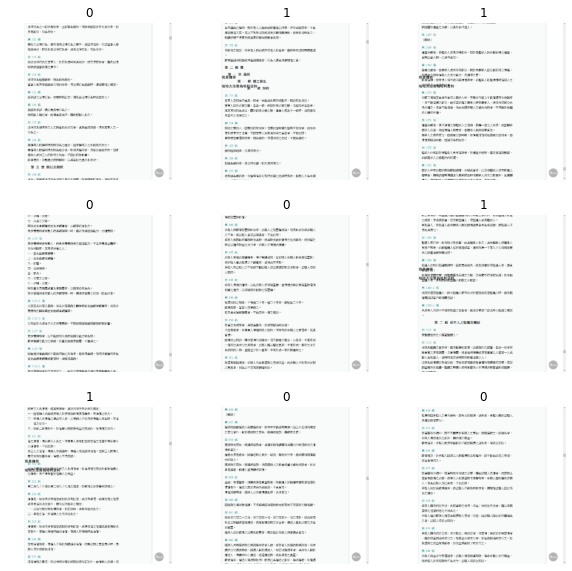

In [19]:

plt.figure(figsize=(10, 10))

for images, labels in train_df.take(1):
  print(images.shape)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")


In [ ]:
# Check image and label pair is matched.
# Show images from tensorflow datasets: directly show image from dataset might return blank
# Use visualize functions: tfds.show_examples
'''
import tensorflow_datasets as tfds
from PIL import Image

class_dict = {'0':'normal', '1':'overlap'}

for images, labels in train_df.take(1):

  images = np.array(images)
  labels = np.array(labels)

  for i in range(len(images)):

    image = (images[i]).astype(np.uint8)
    label = int(labels[i][0])
    img = Image.fromarray(image)
    label = class_dict[str(label)]

    img.save('{}_num{}.png'.format(label, i))
'''

In [ ]:
# Data loader for normal image and overlap image

# image_dataset_from_directory parameters:
# label_mode: int: label is int32 with size(batch_size). binary: label = float32 with size(batch_size, 1). categorical: label=float32 with size(batch_size, num_class)
# colormode: automatically convert input image to the n_channels. rgb: 3 channel, rgba: 4 channel, grayscale: 1 channel

'''
import random
import glob, sys


img_list = glob.glob('/content/drive/MyDrive/binary/total_image/*.png')

# Train/validation split
test_size = 0.2
test_samples = int(len(img_list)*0.2)
valid_list = list(random.sample(img_list, test_samples))
train_list = list(set(img_list) - set(valid_list))

print('Number of train samples: ', len(train_list))
print('Number of valid samples: ', len(valid_list))

'''

#ImageDataGenerator: generate image from batches of 4D array data, but one generator could fit on train and validation data seperately

'''
data_gen = keras.preprocessing.image.ImageDataGenerator(
  horizontal_flip = True,
  vertical_flip = True
)

valid_gen = keras.preprocessing.image.ImageDataGenerator(
  horizontal_flip = True,
  vertical_flip = True
)

train_images = []
for i in range(len(train_list)):
  img = plt.imread(train_list[i])
  img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
  img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
  train_images.append(img)

print('Load train image finished.')
valid_images = []
for i in range(len(valid_list)):
  img = plt.imread(valid_list[i])
  img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
  img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
  valid_images.append(img) 

print('Load Valid image finished.')

print(train_images[0].dtype)
print('Size cost of train_images:', (sys.getsizeof(train_images)))

train_images = np.stack(train_images, axis=0)
valid_images = np.stack(valid_images, axis=0)

print('Fitting train_images..')
data_gen.fit(train_images)
gc.collect()

#print('Fitting valid_images..')
#valid_gen.fit(valid_images)


img_path = '/content/drive/MyDrive/binary/total_image'

label_file = pd.DataFrame(columns = ['image', 'label'])
label_file['image'] = [file for file in os.listdir(img_path) if '.png' in file]

for i in range(len(label_file)):
    if 'add' in label_file.iloc[i]['image']:
        label_file.iloc[i]['label'] = 1
        
    elif 'text' in label_file.iloc[i]['image']:
        label_file.iloc[i]['label'] = 0

train_label = []
valid_label = []

train_order = [file.split('/')[-1] for file in train_list]
valid_order = [file.split('/')[-1] for file in valid_list]

train_label = label_file.set_index('image').reindex(train_order).reset_index()
valid_label = label_file.set_index('image').reindex(valid_order).reset_index()


train_label = train_label['label']
valid_label = valid_label['label']

'''

In [20]:
model.compile(
    optimizer = keras.optimizers.Adam(1e-5),
    loss = tf.losses.BinaryCrossentropy(from_logits = True),
    metrics=['accuracy']
    )

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500, 522, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 506, 528, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 250, 261, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 250, 261, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# datagen.flow: Iterator yield tuples: (input_samples, labels)
import multiprocessing

Iterations = 15

callbacks = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 5,
    verbose = 2
)

gc.collect()
history = model.fit(
    train_df,
    validation_data=valid_df,
    epochs = Iterations,
    callbacks = [callbacks],
    )


gc.collect()

Epoch 1/15
96/96 [==============================] - 506s 5s/step - loss: 1.1599 - accuracy: 0.5116 - val_loss: 0.9544 - val_accuracy: 0.4883
Epoch 2/15
96/96 [==============================] - 79s 823ms/step - loss: 0.0092 - accuracy: 0.5116 - val_loss: 0.7774 - val_accuracy: 0.4883
Epoch 3/15
96/96 [==============================] - 81s 842ms/step - loss: 0.0097 - accuracy: 0.5116 - val_loss: 0.4049 - val_accuracy: 0.4883
Epoch 4/15
96/96 [==============================] - 82s 853ms/step - loss: 0.0172 - accuracy: 0.5116 - val_loss: 0.0255 - val_accuracy: 0.4883
Epoch 5/15
96/96 [==============================] - 83s 860ms/step - loss: 0.0189 - accuracy: 0.5116 - val_loss: 0.0161 - val_accuracy: 0.4883
Epoch 6/15
96/96 [==============================] - 83s 864ms/step - loss: 0.0114 - accuracy: 0.5116 - val_loss: 0.0179 - val_accuracy: 0.4883
Epoch 7/15
96/96 [==============================] - 83s 863ms/step - loss: 0.0075 - accuracy: 0.5116 - val_loss: 0.0123 - val_accuracy: 0.4883
E

In [ ]:
# Save model on drive 
model.save('txt_overlap_model')
!cp -r txt_overlap_model1 '/content/drive/MyDrive/txt_overlap_model'

gc.collect()

In [ ]:
# Clear session

from keras import backend as K

del model, re_model
K.clear_session()

from numba import cuda
cuda.select_device(0)
cuda.close()

gc.collect()

In [ ]:
%cd /content

gc.collect()
re_model = keras.models.load_model('txt_overlap_model')

gc.collect()

In [ ]:
re_model.summary()

In [ ]:


def preprocess_img(img):
  '''
  img: input image directory
  output: processed image array could feed to predictive model

  '''

  img1 = plt.imread(img)
  img1 = cv2.resize(img1, (IMAGE_WIDTH, IMAGE_HEIGHT))
  img1 = cv2.cvtColor(img1, cv2.COLOR_RGBA2RGB)
  img1 = np.expand_dims(img1, axis = 0)

  return img1

class_labels = {'0':'normal', '1':'overlap'}

def decode_prediction(pred):

  predict = np.argmax(pred[0])
  predict_label = class_labels[str(predict)]

  return predict_label


In [ ]:
import glob

gc.collect()

#model = keras.models.load_model('/content/drive/MyDrive/temp/txt_overlap_model1')

#images = []
images = glob.glob('/content/drive/MyDrive/binary/normal/*.png')
images = images + glob.glob('/content/drive/MyDrive/binary/overlap/*.png')

predictions = []

for img in images:

  image = preprocess_img(img)

  predict = re_model.predict(image)

  predict_label = decode_prediction(predict)

  predictions.append(predict_label)

  del image, predict, predict_label
  gc.collect()

print('Predicted {} samples.'.format(len(predictions)))


In [ ]:
plt.hist(predictions)

plt.show()

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb  2 17:17:12 2021

@author: lawrence123
"""

# Visualize object in image: Grad CAM
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import imutils

from keras import Model as Model

# import the necessary packages

class GradCAM():
  def __init__(self, model, classIdx, layerName=None):
    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName == None:
    	self.layerName = self.find_target_layer()
   
  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
    	# check to see if the layer has a 4D output
    	if len(layer.output_shape) == 4:
	    		return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
  
  def compute_heatmap(self, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = Model(
      inputs=[self.model.inputs],
      outputs=[self.model.get_layer(self.layerName).output, self.model.output])

    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
    # cast the image tensor to a float-32 data type, pass the
    # image through the gradient model, and grab the loss
    # associated with the specific class index
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
 
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
        return (heatmap, output)


In [ ]:
from keras.applications.resnet50 import decode_predictions

preds = model.predict(img1)

class_labels = {'0':'normal', '1':'overlap'}

def decode_prediction(pred):

  predict = np.argmax(pred[0])
  predict_label = class_labels[str(predict)]

  return predict_label

i = np.argmax(preds[0])
# decode the ImageNet predictions to obtain the human-readable label
decoded = decode_prediction(preds)



(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))


In [ ]:
i